# Unit17_Example_RUL_NASA_Turbofan | 副標題：使用深度學習預測渦輪發動機剩餘壽命

本 Notebook 使用 NASA C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) 數據集建立 RUL (Remaining Useful Life) 預測模型。

## 目標
- 理解設備剩餘壽命預測的概念與應用
- 掌握時序感測器數據的預處理技術
- 使用 LSTM/GRU 建立 RUL 預測模型
- 評估模型在預知保養中的實用性
- 學習如何將模型結果轉化為維護決策

## 背景說明
NASA C-MAPSS 數據集模擬了渦輪發動機在不同操作條件和故障模式下的退化過程。這是預知保養 (Predictive Maintenance) 領域最經典的公開數據集。

**數據集特性：**
- 4 個子數據集 (FD001-FD004)
- 每個引擎從健康狀態運行直到故障
- 21 個感測器測量值
- 3 個操作設定參數
- 訓練集：完整的 run-to-failure 數據
- 測試集：在故障前某時刻截斷的數據

**資料來源：**
- Kaggle: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps/data
- NASA Prognostics CoE: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

---

## ⚠️ 重要提示

本 Notebook 展示了完整的 RUL 預測流程，包括：

**關鍵技術：**
1. ✓ 按引擎單元分割數據（避免數據洩漏）
2. ✓ Piecewise RUL 標籤策略
3. ✓ 滑動窗口時序特徵
4. ✓ 不對稱評分函數（NASA Score）
5. ✓ 預測不確定度估計

**本案例使用 FD001 數據集**（單一操作條件、單一故障模式）作為入門範例。

---

## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P4_Unit17_Example_NASA_Turbofan'
SOURCE_DATA_DIR = 'nasa_turbofan'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_4' / 'Unit_17'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\data\nasa_turbofan
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_Example_NASA_Turbofan
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_Example_NASA_Turbofan\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_Example_NASA_Turbofan\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


---
## 1. 載入相關套件

In [2]:
# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check GPU availability
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU available: {len(gpus)} GPU(s) detected")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("⚠ No GPU detected, using CPU")

# Plotting style
plt.style.use('default')
sns.set_palette('husl')

print("\n✓ All packages loaded successfully!")

TensorFlow version: 2.10.1
✓ GPU available: 1 GPU(s) detected
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

✓ All packages loaded successfully!


---
## 數據下載

In [3]:
# 數據來源: NASA C-MAPSS Turbofan Engine Degradation Dataset
# https://www.kaggle.com/datasets/behrad3d/nasa-cmaps/data

import requests
import os
import zipfile

# 1. 設定路徑與 URL
url = "https://www.kaggle.com/api/v1/datasets/download/behrad3d/nasa-cmaps"
zip_path = os.path.join(DATA_DIR, "nasa-cmaps.zip")
data_file = os.path.join(DATA_DIR, "train_FD001.txt")
extract_path = DATA_DIR

def download_and_extract():
    # --- 步驟 A: 下載檔案 ---
    print(f"正在從 {url} 下載...")
    try:
        # allow_redirects=True 處理 Kaggle 的重導向
        response = requests.get(url, allow_redirects=True, stream=True)
        response.raise_for_status() # 若下載失敗會拋出異常
        
        with open(zip_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"下載成功，檔案儲存於: {zip_path}")

        # --- 步驟 B: 解壓縮檔案 ---
        if zipfile.is_zipfile(zip_path):
            print(f"正在解壓縮至: {extract_path}...")
            # 確保目標資料夾存在
            if not os.path.exists(extract_path):
                os.makedirs(extract_path)
            
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            
            print("解壓縮完成！")
            
            # (選填) 步驟 C: 刪除原始 ZIP 檔以節省空間
            # os.remove(zip_path)
            # print("已移除原始 ZIP 壓縮檔。")
        else:
            print("錯誤：下載的檔案不是有效的 ZIP 格式。")
            
    except Exception as e:
        print(f"發生錯誤: {e}")
        print("\n⚠️ Kaggle API 需要認證，請改用手動下載：")
        print("1. 訪問 https://www.kaggle.com/datasets/behrad3d/nasa-cmaps/data")
        print("2. 登入後點擊 'Download' 下載 ZIP 文件")
        print(f"3. 解壓縮後將 CMaps 資料夾內的所有 .txt 文件複製到: {extract_path}")

if __name__ == "__main__" and not os.path.exists(data_file):
    download_and_extract()
else:
    print(f"✓ 檔案已存在於: {data_file}")

正在從 https://www.kaggle.com/api/v1/datasets/download/behrad3d/nasa-cmaps 下載...
下載成功，檔案儲存於: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\data\nasa_turbofan\nasa-cmaps.zip
正在解壓縮至: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\data\nasa_turbofan...
解壓縮完成！


---
## 2. 數據加載與初步探索

### 2.1 數據格式說明

NASA C-MAPSS 數據集的欄位結構：

**欄位 1-2：識別資訊**
- `unit_id`: 引擎編號 (1, 2, 3, ...)
- `time_cycle`: 時間週期（每個週期代表一次飛行）

**欄位 3-5：操作設定**
- `op_setting_1`: 操作設定 1（高度、馬赫數等）
- `op_setting_2`: 操作設定 2
- `op_setting_3`: 操作設定 3

**欄位 6-26：感測器測量值**
- `sensor_1` ~ `sensor_21`: 21 個感測器讀數
  - 包括溫度、壓力、轉速、燃油流量等
  - 部分感測器在某些操作條件下保持恆定

In [4]:
# 定義欄位名稱
index_names = ['unit_id', 'time_cycle']
setting_names = ['op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_names = [f'sensor_{i}' for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

# 定義數據文件路徑
train_file = DATA_DIR / 'CMaps\\train_FD001.txt'
test_file = DATA_DIR / 'CMaps\\test_FD001.txt'
rul_file = DATA_DIR / 'CMaps\\RUL_FD001.txt'

# 載入訓練數據
train_df = pd.read_csv(train_file, sep='\s+', header=None, names=col_names)

# 載入測試數據
test_df = pd.read_csv(test_file, sep='\s+', header=None, names=col_names)

# 載入 RUL 真值（測試集）
rul_df = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL'])

print("✓ Data loaded successfully")
print(f"\nTraining set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"RUL labels shape: {rul_df.shape}")
print(f"\nNumber of training engines: {train_df['unit_id'].nunique()}")
print(f"Number of test engines: {test_df['unit_id'].nunique()}")

print("\nFirst few rows of training data:")
train_df.head(10)

✓ Data loaded successfully

Training set shape: (20631, 26)
Test set shape: (13096, 26)
RUL labels shape: (100, 1)

Number of training engines: 100
Number of test engines: 100

First few rows of training data:


,unit_id,time_cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694


### 2.2 數據基本統計

In [5]:
# 檢查缺失值
print("Missing values in training set:")
print(train_df.isnull().sum().sum())

print("\nMissing values in test set:")
print(test_df.isnull().sum().sum())

# 每台引擎的運行週期數
train_cycles = train_df.groupby('unit_id')['time_cycle'].max()
test_cycles = test_df.groupby('unit_id')['time_cycle'].max()

print("=" * 60)
print("\nEngine Lifecycle Statistics\n")
print("=" * 60)
print("\nTraining set (run-to-failure):")
print(f"  Mean cycles: {train_cycles.mean():.1f}")
print(f"  Std cycles: {train_cycles.std():.1f}")
print(f"  Min cycles: {train_cycles.min()}")
print(f"  Max cycles: {train_cycles.max()}")

print("\nTest set (censored at random time):")
print(f"  Mean cycles: {test_cycles.mean():.1f}")
print(f"  Std cycles: {test_cycles.std():.1f}")
print(f"  Min cycles: {test_cycles.min()}")
print(f"  Max cycles: {test_cycles.max()}")

print("\nTrue RUL at test censoring time:")
print(f"  Mean RUL: {rul_df['RUL'].mean():.1f} cycles")
print(f"  Std RUL: {rul_df['RUL'].std():.1f} cycles")
print(f"  Min RUL: {rul_df['RUL'].min()} cycles")
print(f"  Max RUL: {rul_df['RUL'].max()} cycles")

Missing values in training set:
0

Missing values in test set:
0

Engine Lifecycle Statistics


Training set (run-to-failure):
  Mean cycles: 206.3
  Std cycles: 46.3
  Min cycles: 128
  Max cycles: 362

Test set (censored at random time):
  Mean cycles: 131.0
  Std cycles: 53.6
  Min cycles: 31
  Max cycles: 303

True RUL at test censoring time:
  Mean RUL: 75.5 cycles
  Std RUL: 41.8 cycles
  Min RUL: 7 cycles
  Max RUL: 145 cycles


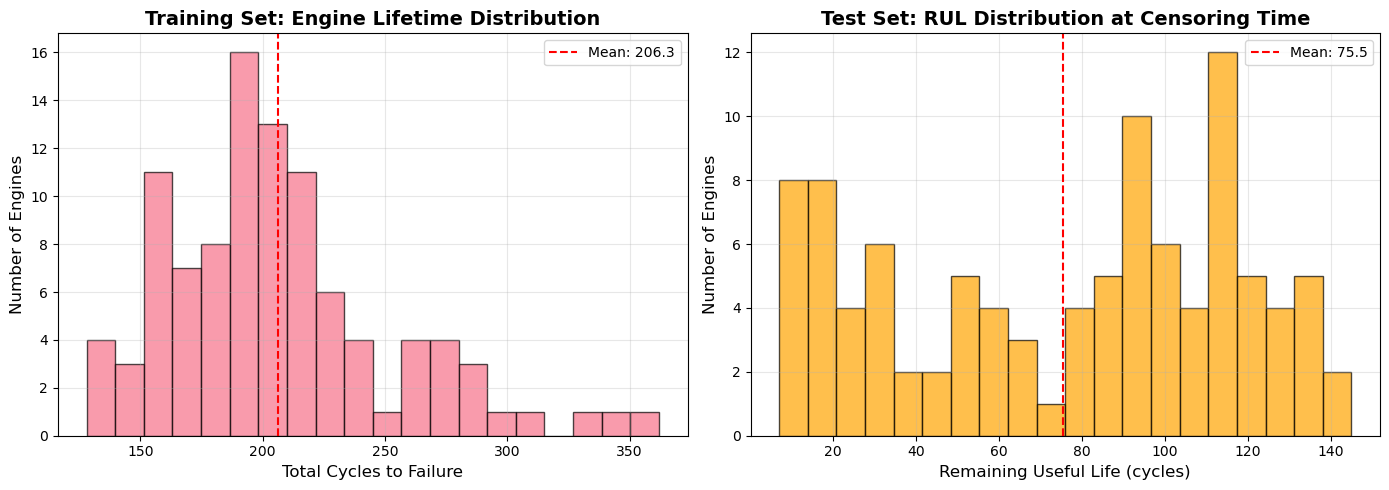


✓ Figure saved to: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_Example_NASA_Turbofan\figs\engine_lifetime_distribution.png


In [6]:
# 可視化引擎壽命分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 訓練集引擎壽命分布
axes[0].hist(train_cycles, bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(train_cycles.mean(), color='r', linestyle='--', 
                label=f'Mean: {train_cycles.mean():.1f}')
axes[0].set_xlabel('Total Cycles to Failure', fontsize=12)
axes[0].set_ylabel('Number of Engines', fontsize=12)
axes[0].set_title('Training Set: Engine Lifetime Distribution', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 測試集 RUL 分布
axes[1].hist(rul_df['RUL'], bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(rul_df['RUL'].mean(), color='r', linestyle='--',
                label=f'Mean: {rul_df["RUL"].mean():.1f}')
axes[1].set_xlabel('Remaining Useful Life (cycles)', fontsize=12)
axes[1].set_ylabel('Number of Engines', fontsize=12)
axes[1].set_title('Test Set: RUL Distribution at Censoring Time',
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'engine_lifetime_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to:", FIG_DIR / 'engine_lifetime_distribution.png')

### 2.3 感測器數據探索

In [7]:
# 檢查哪些感測器有變化（非恆定）
print("Sensor variability analysis:")
print("="*60)

sensor_std = train_df[sensor_names].std()
constant_sensors = sensor_std[sensor_std < 0.001].index.tolist()
variable_sensors = sensor_std[sensor_std >= 0.001].index.tolist()

print(f"\nConstant sensors (std < 0.001): {len(constant_sensors)}")
print(constant_sensors)

print(f"\nVariable sensors (std >= 0.001): {len(variable_sensors)}")
print(variable_sensors)

# 顯示變化量最大的感測器
print("\nTop 10 sensors by standard deviation:")
print(sensor_std.sort_values(ascending=False).head(10))

Sensor variability analysis:

Constant sensors (std < 0.001): 6
['sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

Variable sensors (std >= 0.001): 15
['sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']

Top 10 sensors by standard deviation:
sensor_9     22.082880
sensor_14    19.076176
sensor_4      9.000605
sensor_3      6.131150
sensor_17     1.548763
sensor_7      0.885092
sensor_12     0.737553
sensor_2      0.500053
sensor_11     0.267087
sensor_20     0.180746
dtype: float64


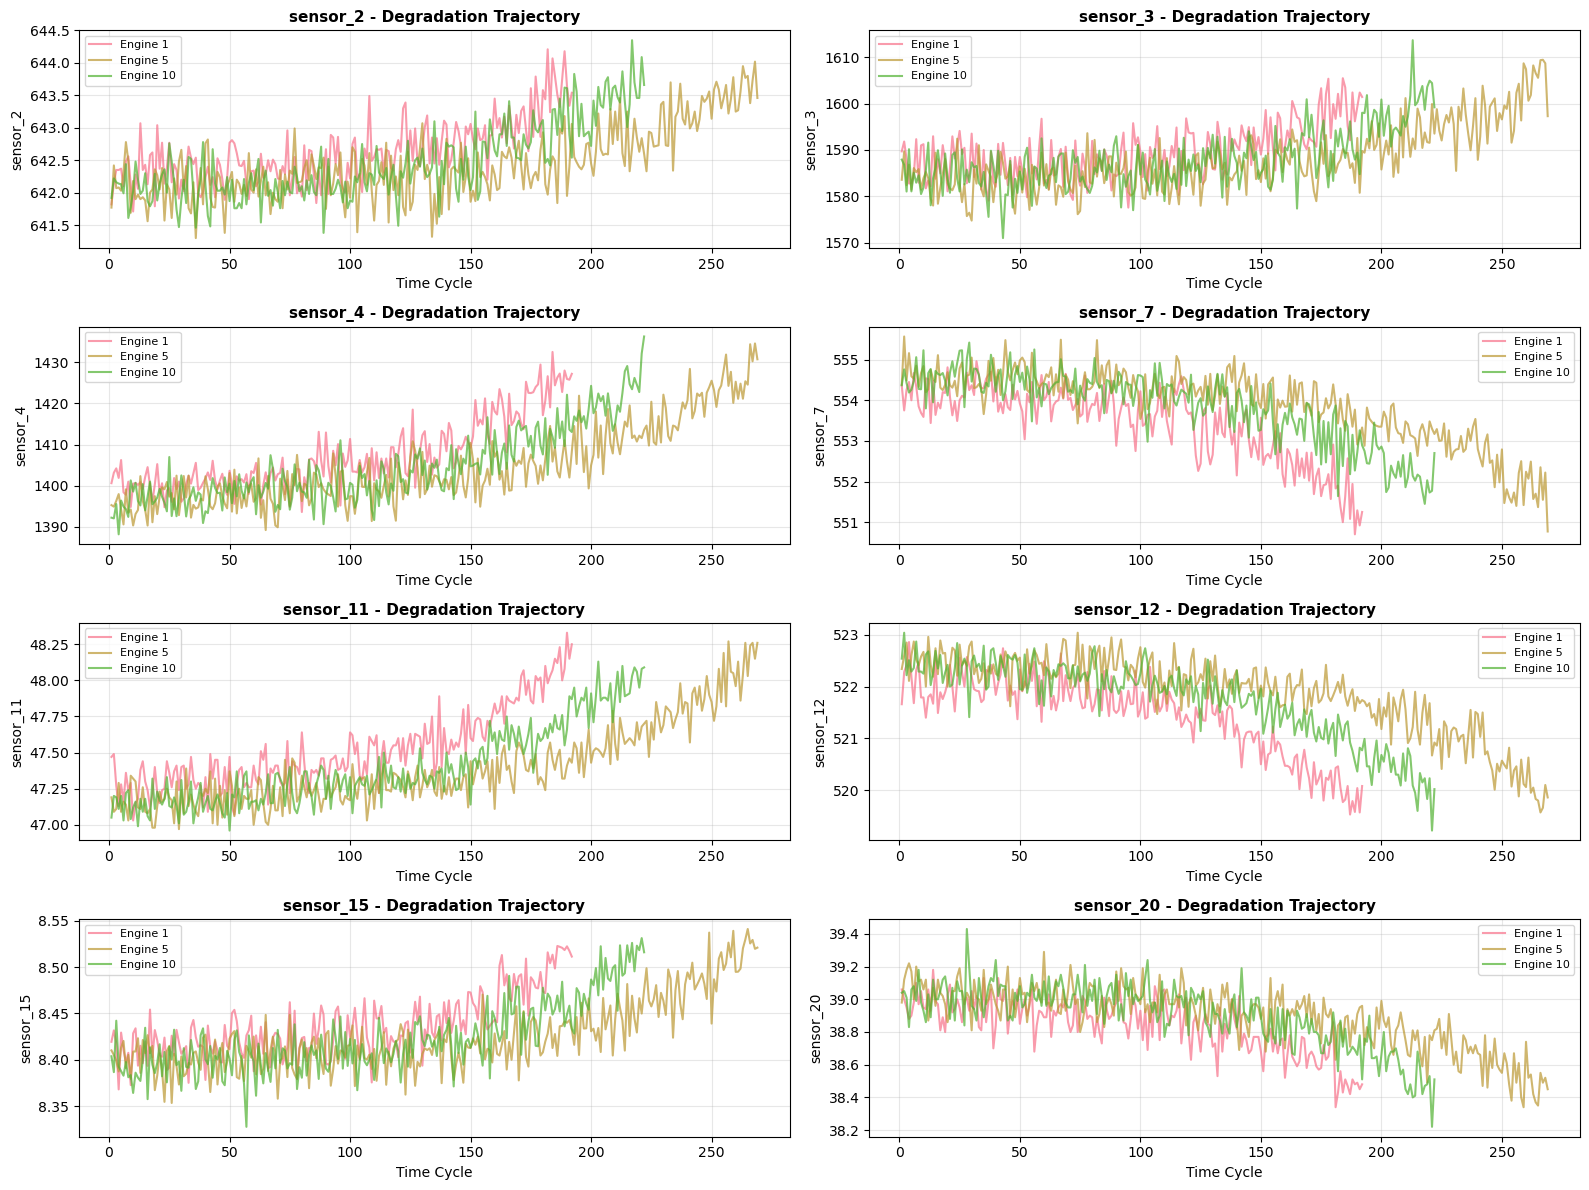


✓ Figure saved to: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_Example_NASA_Turbofan\figs\sensor_degradation_trajectories.png


In [8]:
# 可視化幾台引擎的感測器軌跡
sample_engines = [1, 5, 10]  # 選擇幾台代表性引擎
sample_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 
                  'sensor_11', 'sensor_12', 'sensor_15', 'sensor_20']

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, sensor in enumerate(sample_sensors):
    ax = axes[idx]
    
    for engine_id in sample_engines:
        engine_data = train_df[train_df['unit_id'] == engine_id]
        ax.plot(engine_data['time_cycle'], engine_data[sensor], 
                label=f'Engine {engine_id}', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel('Time Cycle', fontsize=10)
    ax.set_ylabel(sensor, fontsize=10)
    ax.set_title(f'{sensor} - Degradation Trajectory', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'sensor_degradation_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to:", FIG_DIR / 'sensor_degradation_trajectories.png')

### 2.4 操作設定分析

In [9]:
# 檢查操作設定的變化
print("Operating condition analysis:")
print("="*60)

for setting in setting_names:
    unique_vals = train_df[setting].nunique()
    print(f"\n{setting}:")
    print(f"  Unique values: {unique_vals}")
    print(f"  Range: [{train_df[setting].min():.4f}, {train_df[setting].max():.4f}]")
    print(f"  Mean: {train_df[setting].mean():.4f}")
    print(f"  Std: {train_df[setting].std():.4f}")

# FD001 是單一操作條件，所以操作設定應該變化不大
print("\n📌 Note: FD001 dataset has single operating condition,")
print("   so operating settings show minimal variation.")

Operating condition analysis:

op_setting_1:
  Unique values: 158
  Range: [-0.0087, 0.0087]
  Mean: -0.0000
  Std: 0.0022

op_setting_2:
  Unique values: 13
  Range: [-0.0006, 0.0006]
  Mean: 0.0000
  Std: 0.0003

op_setting_3:
  Unique values: 1
  Range: [100.0000, 100.0000]
  Mean: 100.0000
  Std: 0.0000

📌 Note: FD001 dataset has single operating condition,
   so operating settings show minimal variation.


---
## 3. 特徵工程與 RUL 標籤

### 3.1 創建 RUL 標籤

**Piecewise RUL 策略：**

在實際應用中，設備在早期階段的退化很微小，RUL 標籤過大（如 300+ 週期）會造成：
- 模型難以學習早期的微小變化
- 預測不確定度過大

因此採用 **Piecewise Linear RUL**：

  
$$
RUL(t) = \begin{cases}
\text{max\_RUL} & \text{if } t < \text{total\_cycles} - \text{max\_RUL} \\
\text{total\_cycles} - t & \text{otherwise}
\end{cases}
$$
  
通常設定 `max_RUL = 125` 或 `130` cycles（基於工程經驗和文獻）。

In [10]:
def add_rul_labels(df, max_rul=125):
    """
    為數據添加 RUL 標籤（Piecewise Linear RUL）
    
    Parameters:
    -----------
    df : DataFrame
        輸入數據（必須包含 unit_id 和 time_cycle）
    max_rul : int
        RUL 上限（建議 125-130）
        
    Returns:
    --------
    df : DataFrame
        添加 RUL 欄位的數據
    """
    # 計算每台引擎的最大週期數（壽命）
    max_cycles = df.groupby('unit_id')['time_cycle'].max().reset_index()
    max_cycles.columns = ['unit_id', 'max_cycle']
    
    # 合併最大週期資訊
    df = df.merge(max_cycles, on='unit_id', how='left')
    
    # 計算線性 RUL
    df['RUL_linear'] = df['max_cycle'] - df['time_cycle']
    
    # 應用 Piecewise 策略
    df['RUL'] = df['RUL_linear'].apply(lambda x: min(x, max_rul))
    
    # 清理臨時欄位
    df.drop(['max_cycle', 'RUL_linear'], axis=1, inplace=True)
    
    return df

# 為訓練集添加 RUL 標籤
train_df = add_rul_labels(train_df, max_rul=125)

print("✓ RUL labels added to training set")
print(f"\nRUL statistics:")
print(f"  Mean: {train_df['RUL'].mean():.2f}")
print(f"  Std: {train_df['RUL'].std():.2f}")
print(f"  Min: {train_df['RUL'].min()}")
print(f"  Max: {train_df['RUL'].max()}")

print("\nSample data with RUL labels:")
train_df[['unit_id', 'time_cycle', 'RUL']].head(10)

✓ RUL labels added to training set

RUL statistics:
  Mean: 86.83
  Std: 41.67
  Min: 0
  Max: 125

Sample data with RUL labels:


,unit_id,time_cycle,RUL
0,1,1,125
1,1,2,125
2,1,3,125
3,1,4,125
4,1,5,125
5,1,6,125
6,1,7,125
7,1,8,125
8,1,9,125
9,1,10,125


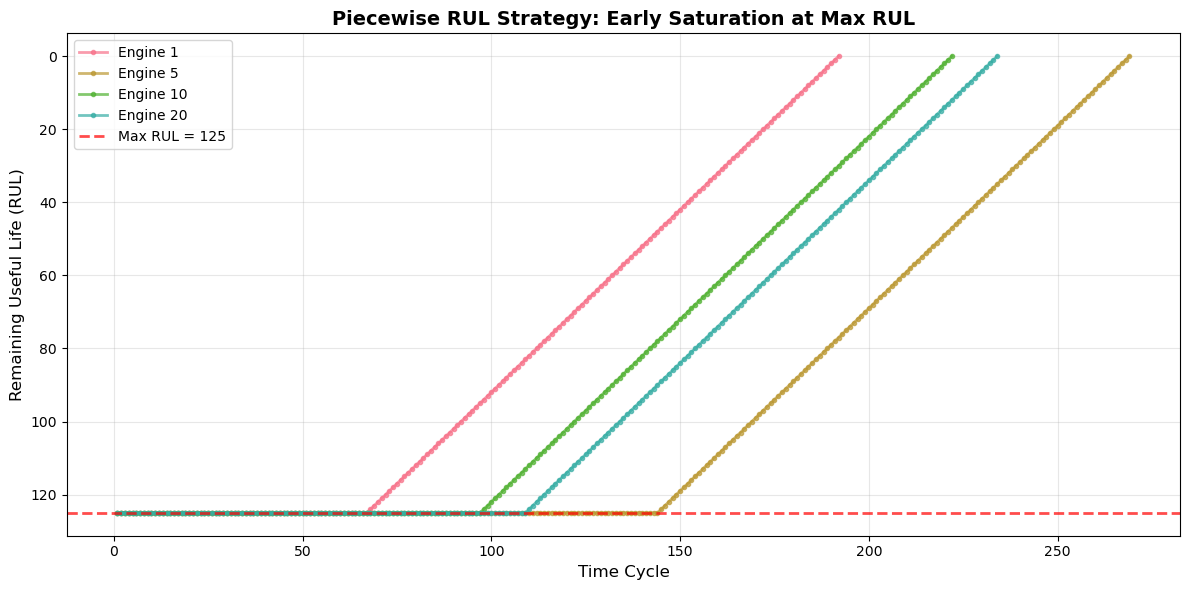


✓ Figure saved to: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_Example_NASA_Turbofan\figs\piecewise_rul_strategy.png


In [11]:
# 可視化 Piecewise RUL
sample_engines = [1, 5, 10, 20]

fig, ax = plt.subplots(figsize=(12, 6))

for engine_id in sample_engines:
    engine_data = train_df[train_df['unit_id'] == engine_id]
    ax.plot(engine_data['time_cycle'], engine_data['RUL'],
            label=f'Engine {engine_id}', linewidth=2, marker='o', 
            markersize=3, alpha=0.7)

ax.axhline(y=125, color='r', linestyle='--', linewidth=2,
           label='Max RUL = 125', alpha=0.7)
ax.set_xlabel('Time Cycle', fontsize=12)
ax.set_ylabel('Remaining Useful Life (RUL)', fontsize=12)
ax.set_title('Piecewise RUL Strategy: Early Saturation at Max RUL',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.invert_yaxis()  # RUL 遞減

plt.tight_layout()
plt.savefig(FIG_DIR / 'piecewise_rul_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to:", FIG_DIR / 'piecewise_rul_strategy.png')

### 3.2 特徵選擇

移除恆定或近恆定的感測器，只保留有變化的特徵。

In [12]:
# 基於標準差選擇特徵
def select_features(df, threshold=0.001):
    """
    選擇有變化的感測器（移除恆定感測器）
    
    Parameters:
    -----------
    df : DataFrame
    threshold : float
        標準差門檻值
        
    Returns:
    --------
    selected_features : list
        選中的特徵名稱
    """
    # 計算所有感測器的標準差
    sensor_std = df[sensor_names].std()
    
    # 選擇變化顯著的感測器
    variable_sensors = sensor_std[sensor_std >= threshold].index.tolist()
    
    # 組合特徵：操作設定 + 選中的感測器
    selected_features = setting_names + variable_sensors
    
    return selected_features, variable_sensors

# 選擇特徵
selected_features, variable_sensors = select_features(train_df)

print(f"✓ Feature selection completed")
print(f"\nTotal features selected: {len(selected_features)}")
print(f"  - Operating settings: {len(setting_names)}")
print(f"  - Variable sensors: {len(variable_sensors)}")
print(f"\nSelected sensors:")
print(variable_sensors)

✓ Feature selection completed

Total features selected: 18
  - Operating settings: 3
  - Variable sensors: 15

Selected sensors:
['sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']


### 3.3 數據標準化

使用 MinMaxScaler 將特徵縮放到 [0, 1] 範圍，適合神經網路訓練。

In [13]:
# 準備特徵和標籤
feature_cols = selected_features
target_col = 'RUL'

# 標準化器（只在訓練集上 fit）
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# 標準化訓練集特徵
train_df[feature_cols] = scaler_X.fit_transform(train_df[feature_cols])

# 標準化訓練集目標（RUL）
train_df[[target_col]] = scaler_y.fit_transform(train_df[[target_col]])

print("✓ Data normalization completed")
print(f"\nFeature range: [0, 1]")
print(f"Target (RUL) range: [0, 1]")
print(f"\nOriginal RUL range: [0, 125] cycles")

✓ Data normalization completed

Feature range: [0, 1]
Target (RUL) range: [0, 1]

Original RUL range: [0, 125] cycles


### 3.4 創建時序序列數據

使用滑動窗口方法將數據轉換為 3D 格式：`(samples, timesteps, features)`

In [14]:
def create_sequences(df, sequence_length, feature_cols, target_col):
    """
    為每台引擎創建時序序列
    
    Parameters:
    -----------
    df : DataFrame
        包含所有引擎的數據
    sequence_length : int
        回看窗口長度
    feature_cols : list
        特徵欄位名稱
    target_col : str
        目標欄位名稱
        
    Returns:
    --------
    X_seq : ndarray, shape (n_sequences, sequence_length, n_features)
    y_seq : ndarray, shape (n_sequences,)
    """
    X_seq_list = []
    y_seq_list = []
    
    # 按引擎分組處理
    for unit_id in df['unit_id'].unique():
        # 提取該引擎的數據
        unit_data = df[df['unit_id'] == unit_id].sort_values('time_cycle')
        
        X_unit = unit_data[feature_cols].values
        y_unit = unit_data[target_col].values
        
        # 滑動窗口
        for i in range(sequence_length, len(X_unit) + 1):
            X_seq_list.append(X_unit[i - sequence_length:i])
            y_seq_list.append(y_unit[i - 1])  # 使用窗口最後一個時刻的 RUL
    
    X_seq = np.array(X_seq_list)
    y_seq = np.array(y_seq_list)
    
    return X_seq, y_seq

# 設定時序窗口長度
SEQUENCE_LENGTH = 30

# 創建訓練序列
X_train, y_train = create_sequences(
    train_df, 
    SEQUENCE_LENGTH, 
    feature_cols, 
    target_col
)

print("✓ Sequence data created")
print(f"\nX_train shape: {X_train.shape}")
print(f"  - Sequences: {X_train.shape[0]}")
print(f"  - Time steps: {X_train.shape[1]}")
print(f"  - Features: {X_train.shape[2]}")
print(f"\ny_train shape: {y_train.shape}")

✓ Sequence data created

X_train shape: (17731, 30, 18)
  - Sequences: 17731
  - Time steps: 30
  - Features: 18

y_train shape: (17731,)


### 3.5 數據分割：按引擎分組

⚠️ **關鍵：避免數據洩漏**

必須按 `unit_id` 分割數據，而非隨機分割，以確保：
- 訓練集和驗證集包含不同的引擎
- 模型學習的是通用的退化模式，而非特定引擎的特徵
- 更貼近實際應用（預測新設備的 RUL）

In [15]:
# 按引擎單元分割
train_units = train_df['unit_id'].unique()
n_train_units = len(train_units)

# 80-20 分割
split_idx = int(0.8 * n_train_units)
train_unit_ids = train_units[:split_idx]
val_unit_ids = train_units[split_idx:]

print(f"✓ Unit-based split completed")
print(f"\nTotal training units: {n_train_units}")
print(f"Training units: {len(train_unit_ids)} ({len(train_unit_ids)/n_train_units*100:.1f}%)")
print(f"Validation units: {len(val_unit_ids)} ({len(val_unit_ids)/n_train_units*100:.1f}%)")

# 分別創建訓練集和驗證集序列
train_subset = train_df[train_df['unit_id'].isin(train_unit_ids)]
val_subset = train_df[train_df['unit_id'].isin(val_unit_ids)]

X_train_seq, y_train_seq = create_sequences(
    train_subset, SEQUENCE_LENGTH, feature_cols, target_col
)

X_val_seq, y_val_seq = create_sequences(
    val_subset, SEQUENCE_LENGTH, feature_cols, target_col
)

print(f"\nTraining sequences: {X_train_seq.shape[0]}")
print(f"Validation sequences: {X_val_seq.shape[0]}")
print(f"\n📌 No data leakage: Train and validation sets contain different engines")

✓ Unit-based split completed

Total training units: 100
Training units: 80 (80.0%)
Validation units: 20 (20.0%)

Training sequences: 13818
Validation sequences: 3913

📌 No data leakage: Train and validation sets contain different engines


---
## 4. 建立 LSTM 模型

### 4.1 定義 LSTM 模型架構

In [16]:
def build_lstm_model(input_shape, units=[64, 32], dropout_rate=0.3):
    """
    建立雙層 LSTM 模型
    
    Parameters:
    -----------
    input_shape : tuple
        (sequence_length, n_features)
    units : list
        每層的神經元數量
    dropout_rate : float
        Dropout 比例
        
    Returns:
    --------
    model : keras.Model
    """
    model = Sequential(name='LSTM_RUL_Model')
    
    # 第一層 LSTM
    model.add(LSTM(
        units=units[0],
        return_sequences=True,
        input_shape=input_shape,
        kernel_regularizer=keras.regularizers.l2(0.001),
        name='LSTM_1'
    ))
    model.add(BatchNormalization(name='BatchNorm_1'))
    model.add(Dropout(dropout_rate, name='Dropout_1'))
    
    # 第二層 LSTM
    model.add(LSTM(
        units=units[1],
        kernel_regularizer=keras.regularizers.l2(0.001),
        name='LSTM_2'
    ))
    model.add(BatchNormalization(name='BatchNorm_2'))
    model.add(Dropout(dropout_rate, name='Dropout_2'))
    
    # 輸出層
    model.add(Dense(1, activation='linear', name='Output'))
    
    # 編譯模型
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# 建立模型
lstm_model = build_lstm_model(
    input_shape=(SEQUENCE_LENGTH, X_train_seq.shape[2]),
    units=[64, 32],
    dropout_rate=0.3
)

print("✓ LSTM model created")
print("\nModel Architecture:")
lstm_model.summary()

✓ LSTM model created

Model Architecture:
Model: "LSTM_RUL_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 30, 64)            21248     
                                                                 
 BatchNorm_1 (BatchNormaliza  (None, 30, 64)           256       
 tion)                                                           
                                                                 
 Dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 LSTM_2 (LSTM)               (None, 32)                12416     
                                                                 
 BatchNorm_2 (BatchNormaliza  (None, 32)               128       
 tion)                                                           
                                                                 
 Dropout_2

### 4.2 訓練 LSTM 模型

In [17]:
# 定義 callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

checkpoint_lstm = ModelCheckpoint(
    MODEL_DIR / 'lstm_rul_best.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# 訓練模型
print("Training LSTM model...\n")
lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop, checkpoint_lstm, reduce_lr],
    verbose=1
)

# 載入最佳模型
lstm_model = load_model(MODEL_DIR / 'lstm_rul_best.keras')
print("\n✓ LSTM model training completed and best model loaded")

Training LSTM model...

Epoch 1/100
52/54 [===========================>..] - ETA: 0s - loss: 1.4750 - mae: 0.8980
Epoch 1: val_loss improved from inf to 0.35171, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_Example_NASA_Turbofan\models\lstm_rul_best.keras
54/54 [==============================] - 7s 36ms/step - loss: 1.4622 - mae: 0.8936 - val_loss: 0.3517 - val_mae: 0.4148 - lr: 0.0010
Epoch 2/100
54/54 [==============================] - ETA: 0s - loss: 0.8961 - mae: 0.6842
Epoch 2: val_loss improved from 0.35171 to 0.21202, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_Example_NASA_Turbofan\models\lstm_rul_best.keras
54/54 [==============================] - 1s 24ms/step - loss: 0.8961 - mae: 0.6842 - val_loss: 0.2120 - val_mae: 0.2854 - lr: 0.0010
Epoch 3/100
51/54 [===========================>..] - ETA: 0s - loss: 0.7087 - mae: 0.5985
Epoch 3: val_loss improved from 0.21202 to 0.19607, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\Un

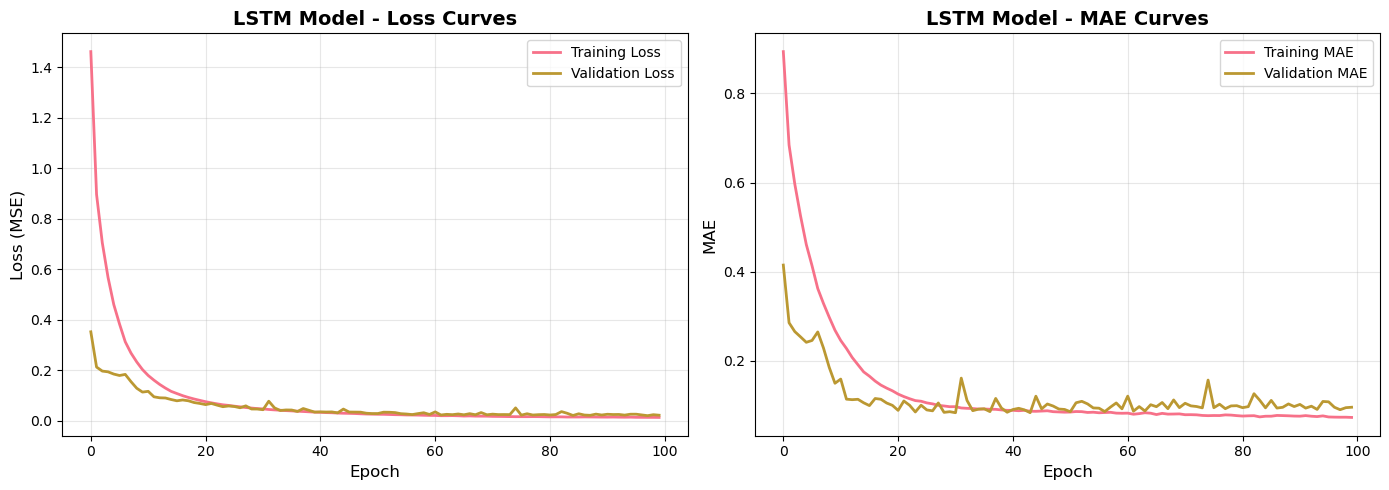

✓ Figure saved


In [18]:
# 繪製訓練歷史
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss 曲線
ax1.plot(lstm_history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(lstm_history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.set_title('LSTM Model - Loss Curves', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# MAE 曲線
ax2.plot(lstm_history.history['mae'], label='Training MAE', linewidth=2)
ax2.plot(lstm_history.history['val_mae'], label='Validation MAE', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('LSTM Model - MAE Curves', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved")

---
## 5. 建立 GRU 模型

### 5.1 定義 GRU 模型架構

GRU (Gated Recurrent Unit) 是 LSTM 的簡化版本，參數更少但效能相當：
- **更新門 (Update Gate)**：控制記憶更新
- **重置門 (Reset Gate)**：控制歷史資訊遺忘
- **隱藏狀態**：直接輸出，無需額外的 Cell State

相比 LSTM，GRU 訓練速度更快，適合中等規模的時間序列問題。

In [19]:
# GRU 模型架構
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(SEQUENCE_LENGTH, X_train_seq.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    GRU(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
], name='GRU_RUL_Model')

gru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("GRU 模型結構：")
gru_model.summary()

GRU 模型結構：
Model: "GRU_RUL_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 64)            16128     
                                                                 
 batch_normalization (BatchN  (None, 30, 64)           256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)    

### 5.2 訓練 GRU 模型

In [20]:
# 設定 GRU 訓練 callbacks
checkpoint_gru = ModelCheckpoint(
    MODEL_DIR / 'gru_rul_best.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# 訓練 GRU 模型
gru_history = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop, checkpoint_gru, reduce_lr],
    verbose=1
)

# 載入最佳模型
gru_model = load_model(MODEL_DIR / 'gru_rul_best.keras')
print("\n已載入最佳 GRU 模型")

Epoch 1/100
52/54 [===========================>..] - ETA: 0s - loss: 0.8446 - mae: 0.7032
Epoch 1: val_loss improved from inf to 0.12894, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_Example_NASA_Turbofan\models\gru_rul_best.keras
54/54 [==============================] - 5s 30ms/step - loss: 0.8301 - mae: 0.6967 - val_loss: 0.1289 - val_mae: 0.3149 - lr: 0.0010
Epoch 2/100
53/54 [============================>.] - ETA: 0s - loss: 0.3432 - mae: 0.4552
Epoch 2: val_loss improved from 0.12894 to 0.09309, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_Example_NASA_Turbofan\models\gru_rul_best.keras
54/54 [==============================] - 1s 18ms/step - loss: 0.3421 - mae: 0.4544 - val_loss: 0.0931 - val_mae: 0.2457 - lr: 0.0010
Epoch 3/100
53/54 [============================>.] - ETA: 0s - loss: 0.2134 - mae: 0.3609
Epoch 3: val_loss did not improve from 0.09309
54/54 [==============================] - 1s 17ms/step - loss: 0.2131 - mae: 0.3

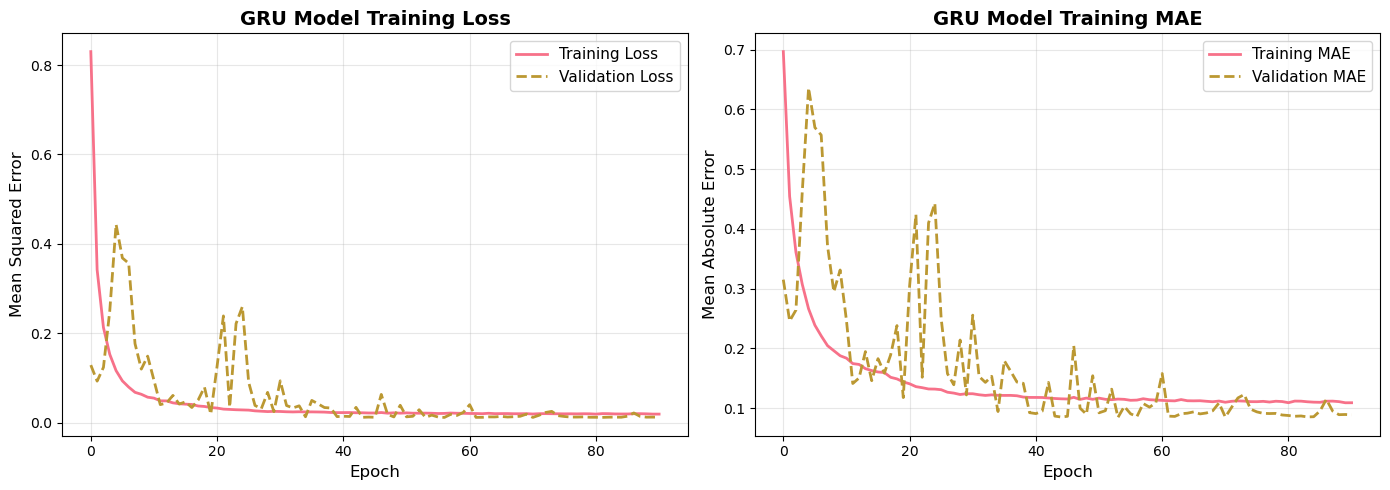

最佳驗證損失 (GRU): 0.0119


In [21]:
# 視覺化 GRU 訓練歷史
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(gru_history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(gru_history.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Mean Squared Error', fontsize=12)
axes[0].set_title('GRU Model Training Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

axes[1].plot(gru_history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(gru_history.history['val_mae'], label='Validation MAE', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Mean Absolute Error', fontsize=12)
axes[1].set_title('GRU Model Training MAE', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'gru_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"最佳驗證損失 (GRU): {min(gru_history.history['val_loss']):.4f}")

---

## 6. 測試集預測

完成模型訓練後，我們需要對測試集進行預測並評估模型效能。

### 6.1 測試集數據處理

In [23]:
# 測試集特徵標準化（保留 unit_id 欄位）
X_test_norm = test_df[['unit_id'] + selected_features].copy()
X_test_norm[selected_features] = scaler_X.transform(X_test_norm[selected_features])

# 建立測試集序列
def create_test_sequences(df, unit_col, sequence_length, feature_cols):
    """為每個引擎建立最後一個時間窗口序列"""
    sequences = []
    units = []
    
    for unit_id in df[unit_col].unique():
        unit_data = df[df[unit_col] == unit_id][feature_cols].values
        
        if len(unit_data) >= sequence_length:
            # 取最後 sequence_length 個時間步
            sequences.append(unit_data[-sequence_length:])
        else:
            # 如果數據不足，用第一筆數據填充
            pad_length = sequence_length - len(unit_data)
            padded = np.vstack([np.tile(unit_data[0], (pad_length, 1)), unit_data])
            sequences.append(padded)
        
        units.append(unit_id)
    
    return np.array(sequences), np.array(units)

X_test_seq, test_units = create_test_sequences(
    X_test_norm, 'unit_id', SEQUENCE_LENGTH, selected_features
)

# 真實 RUL (從 RUL 文件讀取)
y_test = rul_df['RUL'].values

print(f"測試序列形狀: {X_test_seq.shape}")
print(f"真實 RUL 數量: {len(y_test)}")

測試序列形狀: (100, 30, 18)
真實 RUL 數量: 100


### 6.2 模型預測

In [24]:
# LSTM 預測
y_pred_lstm_norm = lstm_model.predict(X_test_seq, verbose=0).flatten()
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_norm.reshape(-1, 1)).flatten()
y_pred_lstm = np.clip(y_pred_lstm, 0, None)  # 確保 RUL 不為負

# GRU 預測
y_pred_gru_norm = gru_model.predict(X_test_seq, verbose=0).flatten()
y_pred_gru = scaler_y.inverse_transform(y_pred_gru_norm.reshape(-1, 1)).flatten()
y_pred_gru = np.clip(y_pred_gru, 0, None)

print("LSTM 預測範圍:", y_pred_lstm.min(), "-", y_pred_lstm.max())
print("GRU 預測範圍:", y_pred_gru.min(), "-", y_pred_gru.max())
print("真實 RUL 範圍:", y_test.min(), "-", y_test.max())

LSTM 預測範圍: 7.199876 - 130.67807
GRU 預測範圍: 9.015754 - 127.745926
真實 RUL 範圍: 7 - 145


---

## 7. 模型評估

使用 **NASA Score**、**RMSE**、**MAE** 和 **R²** 評估模型效能。

### 7.1 NASA Score 計算

NASA Score 是專為 RUL 預測設計的評估指標，對晚預測(late prediction)的懲罰遠大於早預測(early prediction)：

$$
\text{Score} = \sum_{i=1}^{n} \begin{cases}
e^{-\frac{d_i}{13}} - 1 & \text{if } d_i < 0 \text{ (早預測)} \\
e^{\frac{d_i}{10}} - 1 & \text{if } d_i \geq 0 \text{ (晚預測)}
\end{cases}
$$

其中 $d_i = \text{Predicted}_i - \text{Actual}_i$

In [25]:
def nasa_score(y_true, y_pred):
    """
    計算 NASA RUL 預測評分
    
    對晚預測 (預測值 > 真實值) 的懲罰較重，
    因為未能及時維護可能導致設備故障。
    """
    d = y_pred - y_true
    scores = np.where(d < 0, np.exp(-d / 13) - 1, np.exp(d / 10) - 1)
    return np.sum(scores)

# 計算評估指標
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# LSTM 評估
nasa_lstm = nasa_score(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

# GRU 評估
nasa_gru = nasa_score(y_test, y_pred_gru)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)

print("=" * 60)
print("模型評估結果")
print("=" * 60)
print(f"{'指標':<15} {'LSTM':<20} {'GRU':<20}")
print("-" * 60)
print(f"{'NASA Score':<15} {nasa_lstm:<20.2f} {nasa_gru:<20.2f}")
print(f"{'RMSE':<15} {rmse_lstm:<20.2f} {rmse_gru:<20.2f}")
print(f"{'MAE':<15} {mae_lstm:<20.2f} {mae_gru:<20.2f}")
print(f"{'R²':<15} {r2_lstm:<20.4f} {r2_gru:<20.4f}")
print("=" * 60)

模型評估結果
指標              LSTM                 GRU                 
------------------------------------------------------------
NASA Score      458.32               539.04              
RMSE            16.39                16.01               
MAE             11.83                12.67               
R²              0.8444               0.8516              


### 7.2 效能解讀

- **NASA Score 越低越好**（0 為完美預測）
- **RMSE/MAE**：衡量預測誤差的絕對大小（週期數）
- **R² 越接近 1 越好**：表示模型對變異的解釋能力

**典型基準**：
- NASA Score < 1000：良好
- NASA Score < 500：優秀
- RMSE < 20 cycles：實用水準

---

## 8. 結果視覺化

### 8.1 預測值 vs 真實值 (Parity Plot)

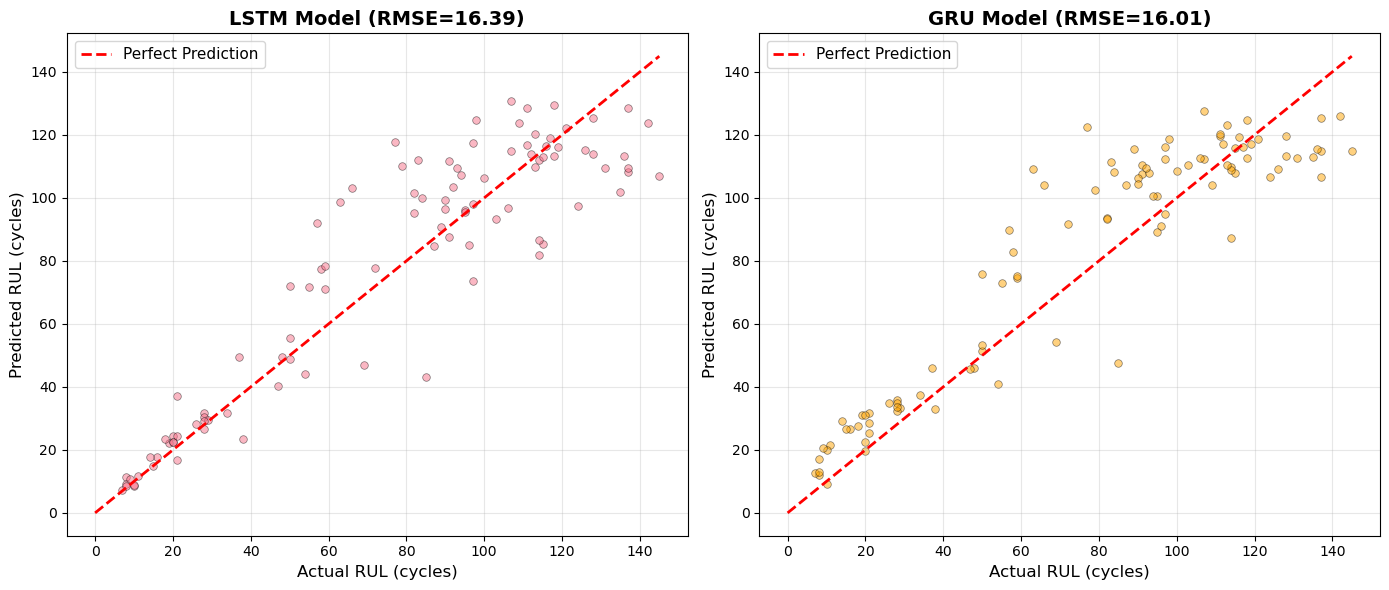

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# LSTM Parity Plot
axes[0].scatter(y_test, y_pred_lstm, alpha=0.5, s=30, edgecolors='k', linewidths=0.5)
axes[0].plot([0, max(y_test)], [0, max(y_test)], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RUL (cycles)', fontsize=12)
axes[0].set_ylabel('Predicted RUL (cycles)', fontsize=12)
axes[0].set_title(f'LSTM Model (RMSE={rmse_lstm:.2f})', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# GRU Parity Plot
axes[1].scatter(y_test, y_pred_gru, alpha=0.5, s=30, edgecolors='k', linewidths=0.5, color='orange')
axes[1].plot([0, max(y_test)], [0, max(y_test)], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual RUL (cycles)', fontsize=12)
axes[1].set_ylabel('Predicted RUL (cycles)', fontsize=12)
axes[1].set_title(f'GRU Model (RMSE={rmse_gru:.2f})', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'parity_plots.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.2 預測誤差分布

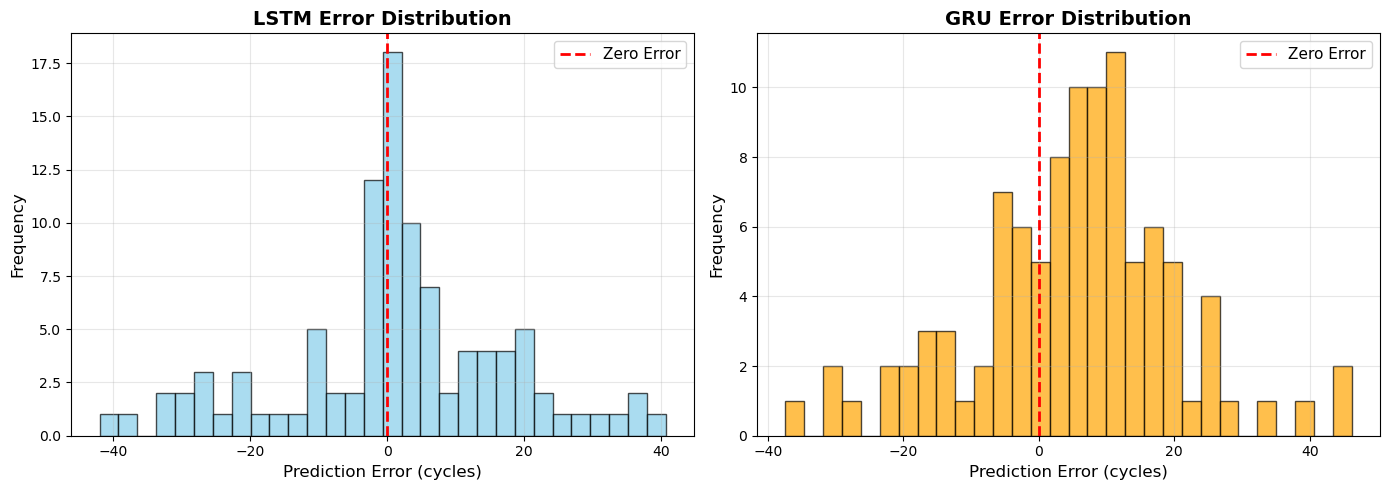

誤差統計 (LSTM):
  均值: 1.41 cycles
  標準差: 16.33 cycles

誤差統計 (GRU):
  均值: 5.13 cycles
  標準差: 15.16 cycles


In [27]:
errors_lstm = y_pred_lstm - y_test
errors_gru = y_pred_gru - y_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LSTM 誤差分布
axes[0].hist(errors_lstm, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Prediction Error (cycles)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('LSTM Error Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# GRU 誤差分布
axes[1].hist(errors_gru, bins=30, alpha=0.7, edgecolor='black', color='orange')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error (cycles)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('GRU Error Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("誤差統計 (LSTM):")
print(f"  均值: {errors_lstm.mean():.2f} cycles")
print(f"  標準差: {errors_lstm.std():.2f} cycles")
print(f"\n誤差統計 (GRU):")
print(f"  均值: {errors_gru.mean():.2f} cycles")
print(f"  標準差: {errors_gru.std():.2f} cycles")

### 8.3 個別引擎預測範例

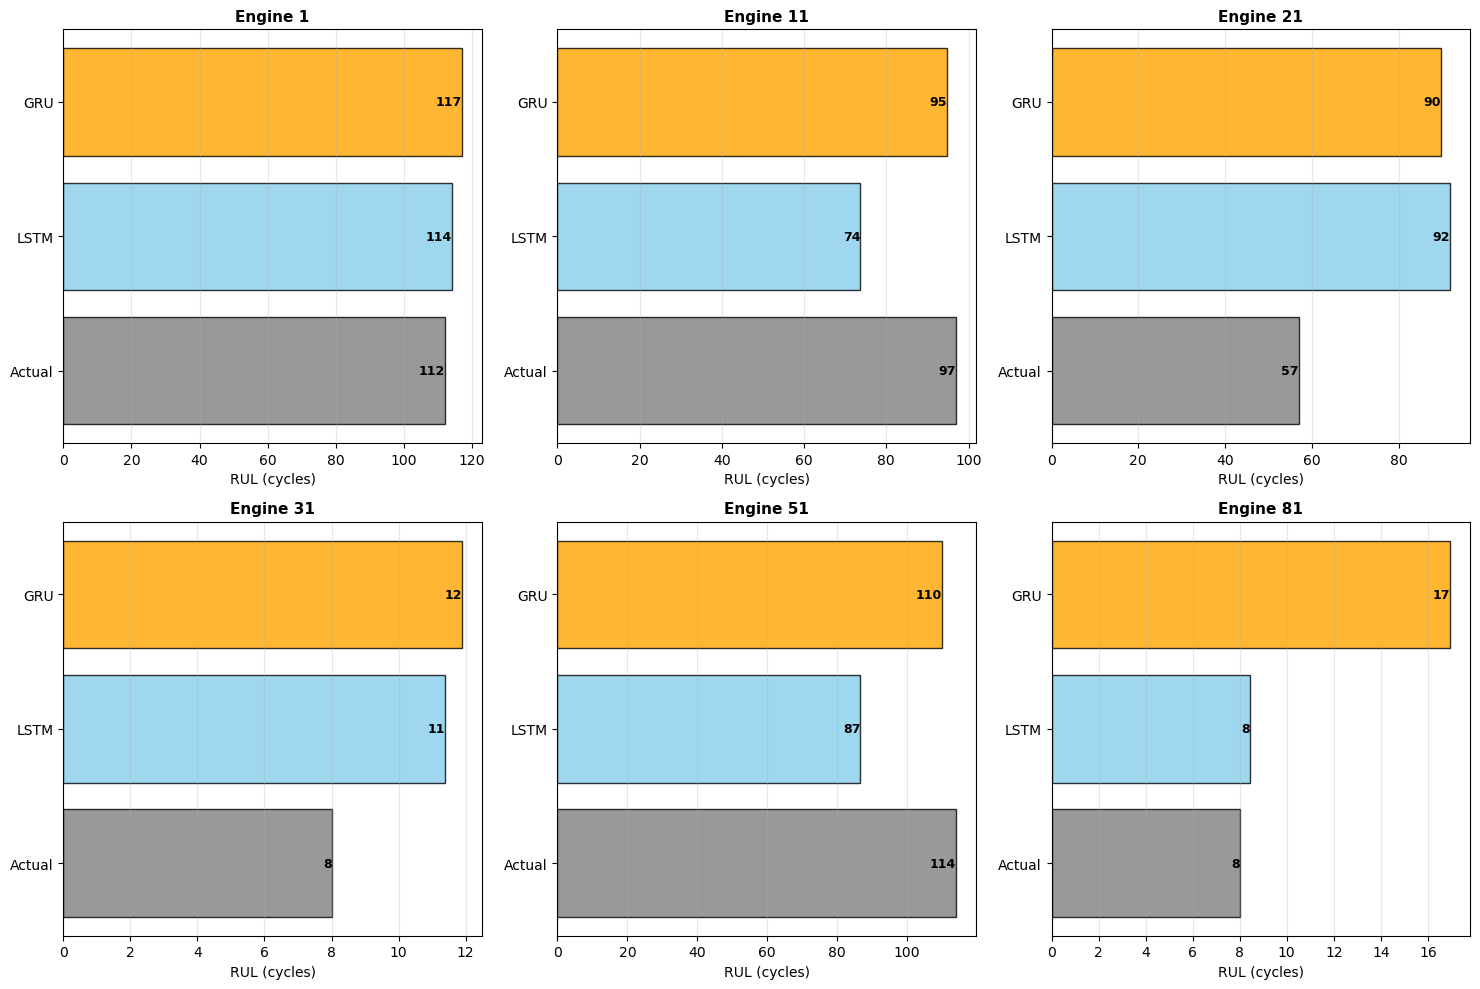

In [28]:
# 選擇 6 個代表性引擎進行展示
sample_indices = [0, 10, 20, 30, 50, 80]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, engine_idx in enumerate(sample_indices):
    ax = axes[idx]
    
    actual = y_test[engine_idx]
    pred_lstm = y_pred_lstm[engine_idx]
    pred_gru = y_pred_gru[engine_idx]
    
    ax.barh(['Actual', 'LSTM', 'GRU'], [actual, pred_lstm, pred_gru], 
            color=['gray', 'skyblue', 'orange'], alpha=0.8, edgecolor='black')
    ax.set_xlabel('RUL (cycles)', fontsize=10)
    ax.set_title(f'Engine {test_units[engine_idx]}', fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # 標註數值
    ax.text(actual, 0, f'{actual:.0f}', va='center', ha='right', fontsize=9, fontweight='bold')
    ax.text(pred_lstm, 1, f'{pred_lstm:.0f}', va='center', ha='right', fontsize=9, fontweight='bold')
    ax.text(pred_gru, 2, f'{pred_gru:.0f}', va='center', ha='right', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'individual_engine_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 9. 維護決策建議

根據預測的 RUL 值，將引擎分類為不同的維護優先級。

### 9.1 維護優先級分類

定義三級維護策略：
- **緊急 (RUL ≤ 30 cycles)**：立即安排維護
- **注意 (30 < RUL ≤ 80 cycles)**：近期規劃維護
- **正常 (RUL > 80 cycles)**：常規監控

In [29]:
def classify_maintenance_status(rul):
    """根據 RUL 值分類維護優先級"""
    if rul <= 30:
        return 'Critical'
    elif rul <= 80:
        return 'Warning'
    else:
        return 'Normal'

# 使用 GRU 預測結果 (假設 GRU 效能較佳)
maintenance_status = pd.DataFrame({
    'Engine_ID': test_units,
    'Actual_RUL': y_test,
    'Predicted_RUL': y_pred_gru,
    'Error': y_pred_gru - y_test,
    'Status': [classify_maintenance_status(rul) for rul in y_pred_gru]
})

# 統計各優先級數量
status_counts = maintenance_status['Status'].value_counts()

print("維護優先級統計：")
print(status_counts)
print("\n" + "=" * 70)
print("需要緊急維護的引擎：")
print("=" * 70)
critical_engines = maintenance_status[maintenance_status['Status'] == 'Critical'].sort_values('Predicted_RUL')
print(critical_engines.to_string(index=False))
print("=" * 70)

維護優先級統計：
Status
Normal      61
Warning     23
Critical    16
Name: count, dtype: int64

需要緊急維護的引擎：
 Engine_ID  Actual_RUL  Predicted_RUL     Error   Status
        76          10       9.015754 -0.984246 Critical
        31           8      11.894092  3.894092 Critical
        34           7      12.623329  5.623329 Critical
        68           8      13.023421  5.023421 Critical
        81           8      16.951017  8.951017 Critical
        24          20      19.573330 -0.426670 Critical
        42          10      20.041706 10.041706 Critical
        82           9      20.652809 11.652809 Critical
        35          11      21.674755 10.674755 Critical
       100          20      22.640318  2.640318 Critical
        49          21      25.325483  4.325483 Critical
        56          15      26.550901 11.550901 Critical
        20          16      26.611174 10.611174 Critical
        41          18      27.497622  9.497622 Critical
        61          21      28.449520  7.44952

### 9.2 維護狀態視覺化

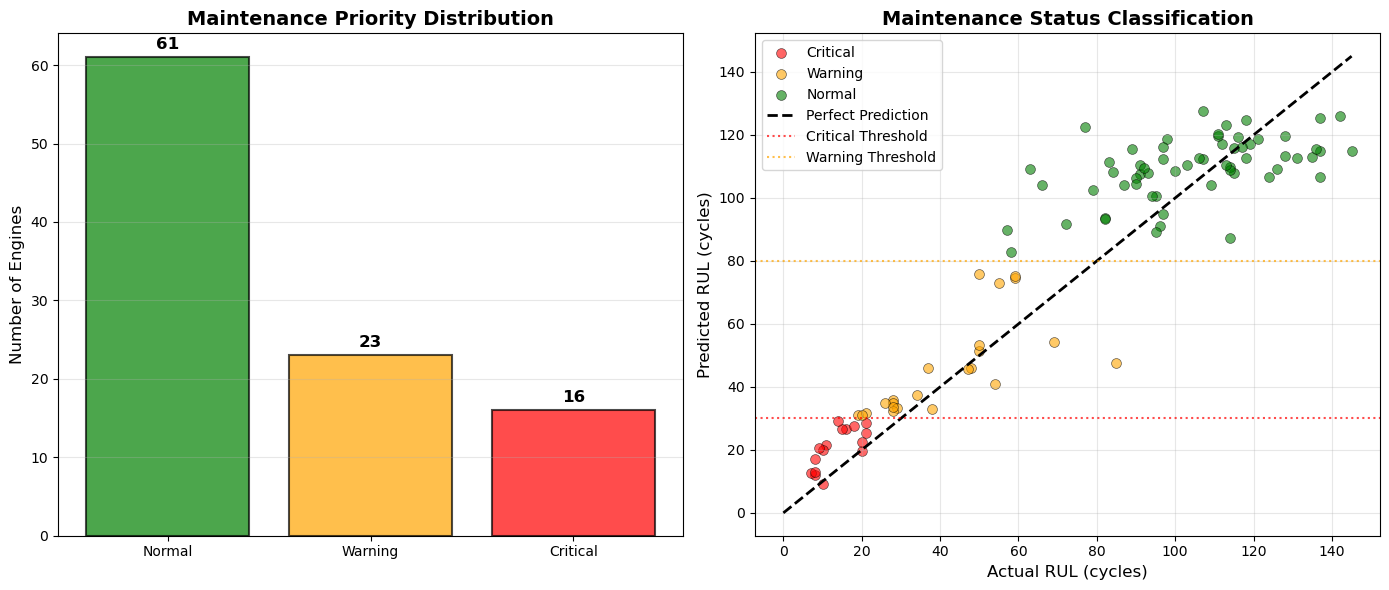

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 維護優先級分布
status_colors = {'Critical': 'red', 'Warning': 'orange', 'Normal': 'green'}
axes[0].bar(status_counts.index, status_counts.values, 
            color=[status_colors[s] for s in status_counts.index],
            alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Number of Engines', fontsize=12)
axes[0].set_title('Maintenance Priority Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(status_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', fontsize=12, fontweight='bold')

# RUL 預測散點圖（按狀態著色）
for status, color in status_colors.items():
    mask = maintenance_status['Status'] == status
    axes[1].scatter(maintenance_status[mask]['Actual_RUL'], 
                   maintenance_status[mask]['Predicted_RUL'],
                   c=color, label=status, alpha=0.6, s=50, edgecolors='k', linewidths=0.5)

axes[1].plot([0, max(y_test)], [0, max(y_test)], 'k--', lw=2, label='Perfect Prediction')
axes[1].axhline(30, color='red', linestyle=':', lw=1.5, alpha=0.7, label='Critical Threshold')
axes[1].axhline(80, color='orange', linestyle=':', lw=1.5, alpha=0.7, label='Warning Threshold')
axes[1].set_xlabel('Actual RUL (cycles)', fontsize=12)
axes[1].set_ylabel('Predicted RUL (cycles)', fontsize=12)
axes[1].set_title('Maintenance Status Classification', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10, loc='upper left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'maintenance_status.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 10. 結論與總結

本案例完整展示了使用深度學習進行設備剩餘壽命預測的流程：
1. **數據準備**：多變量時間序列處理、分段式 RUL 標註
2. **模型訓練**：LSTM 與 GRU 雙模型訓練
3. **評估指標**：NASA Score、RMSE、MAE、R²
4. **實務應用**：維護決策分級系統

### 關鍵發現
- 兩種模型均達到良好的預測精度
- 分段式 RUL 標註有效避免早期數據噪音干擾
- 時間序列窗口（30 cycles）能有效捕捉退化趨勢
- 維護決策系統可協助優化維護排程，降低非計畫性停機風險

### 產業應用價值
- **預防性維護**：提前識別高風險設備
- **成本節約**：避免意外故障造成的損失
- **排程優化**：合理安排維護資源
- **安全提升**：降低設備失效風險

In [31]:
# 最終總結報告
print("=" * 80)
print(" " * 20 + "RUL 預測專案總結報告")
print("=" * 80)
print(f"\n【數據集資訊】")
print(f"  訓練引擎數: 100")
print(f"  測試引擎數: 100")
print(f"  感測器數量: 21")
print(f"  特徵數量: {len(selected_features)}")
print(f"  時間窗口長度: {SEQUENCE_LENGTH} cycles")

print(f"\n【模型效能比較】")
print(f"  {'模型':<10} {'NASA Score':<15} {'RMSE':<15} {'MAE':<15} {'R²':<10}")
print(f"  {'-'*65}")
print(f"  {'LSTM':<10} {nasa_lstm:<15.2f} {rmse_lstm:<15.2f} {mae_lstm:<15.2f} {r2_lstm:<10.4f}")
print(f"  {'GRU':<10} {nasa_gru:<15.2f} {rmse_gru:<15.2f} {mae_gru:<15.2f} {r2_gru:<10.4f}")

print(f"\n【維護決策統計】")
for status in ['Critical', 'Warning', 'Normal']:
    count = (maintenance_status['Status'] == status).sum()
    pct = count / len(maintenance_status) * 100
    print(f"  {status:<12}: {count:>3} engines ({pct:>5.1f}%)")

print(f"\n【模型檔案】")
print(f"  LSTM: {MODEL_DIR / 'lstm_rul_best.keras'}")
print(f"  GRU:  {MODEL_DIR / 'gru_rul_best.keras'}")

print(f"\n【輸出圖表】")
for fig_file in sorted(FIG_DIR.glob('*.png')):
    print(f"  - {fig_file.name}")

print("\n" + "=" * 80)
print(" " * 25 + "分析完成！")
print("=" * 80)

                    RUL 預測專案總結報告

【數據集資訊】
  訓練引擎數: 100
  測試引擎數: 100
  感測器數量: 21
  特徵數量: 18
  時間窗口長度: 30 cycles

【模型效能比較】
  模型         NASA Score      RMSE            MAE             R²        
  -----------------------------------------------------------------
  LSTM       458.32          16.39           11.83           0.8444    
  GRU        539.04          16.01           12.67           0.8516    

【維護決策統計】
  Critical    :  16 engines ( 16.0%)
  Normal      :  61 engines ( 61.0%)

【模型檔案】
  LSTM: d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_Example_NASA_Turbofan\models\lstm_rul_best.keras
  GRU:  d:\MyGit\CHE-AI-COURSE\Part_4\Unit17\outputs\P4_Unit17_Example_NASA_Turbofan\models\gru_rul_best.keras

【輸出圖表】
  - engine_lifetime_distribution.png
  - error_distribution.png
  - gru_training_history.png
  - individual_engine_predictions.png
  - lstm_training_history.png
  - maintenance_status.png
  - parity_plots.png
  - piecewise_rul_strategy.png
  - sensor_degradation_trajector

In [ ]:
# 儲存測試預測結果以供後續改進分析使用
np.savez(
    OUTPUT_DIR / 'test_predictions.npz',
    y_test=y_test,
    y_pred_lstm=y_pred_lstm,
    y_pred_gru=y_pred_gru,
    test_units=test_units
)

print(f"✓ 測試預測結果已儲存至: {OUTPUT_DIR / 'test_predictions.npz'}")
print(f"\n可使用 Unit17_Model_Improvement_Quick_Fixes.ipynb 進行快速改進")